In [1]:
# prompt: kết nối google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras import optimizers

%matplotlib inline
pd.options.display.max_columns = 999

In [3]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())

    return df


def plot_metrics(loss, val_loss):
    fig, (ax1) = plt.subplots(1, 1, sharex='col', figsize=(20,7))
    ax1.plot(loss, label='Train loss')
    ax1.plot(val_loss, label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    plt.xlabel('Epochs')

In [4]:
def safe_json_loads(data):
    """Safely loads JSON data, handling errors."""
    try:
        return json.loads(data)
    except (TypeError, ValueError):
        return {}  # Return empty dict for invalid JSON
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)

    # Kiểm tra cột JSON trước khi thao tác
    for column in JSON_COLUMNS:
        if column in df.columns:
            df[column] = df[column].astype(str)
            df = df.join(pd.DataFrame(df.pop(column).apply(safe_json_loads).values.tolist(), index=df.index))

    return df


In [41]:
train = load_df("/content/drive/My Drive/python/train.csv")
test = load_df("/content/drive/My Drive/python/test.csv")

/tmp/ipython-input-4-2196815949.py:10: DtypeWarning: Columns (0,2,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)
/tmp/ipython-input-4-2196815949.py:10: DtypeWarning: Columns (0,2,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, dtype={'fullVisitorId': 'str'}, nrows=nrows)


In [42]:
train.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,adwordsClickInfo,isTrueDirect,referralPath,adContent,campaignCode
0,Organic Search,20160902.0,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1.472830e+09,1.0,1.472830e+09,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
1,Organic Search,20160902.0,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1.472880e+09,1.0,1.472880e+09,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
2,Organic Search,20160902.0,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1.472865e+09,1.0,1.472865e+09,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN
3,Organic Search,20160902.0,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1.472881e+09,1.0,1.472881e+09,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,google + online,{

In [43]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 799999
Columns: 50
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserVersion' 'browserSize' 'operatingSystem' 'operatingSystemVersion'
 'isMobile' 'mobileDeviceBranding' 'mobileDeviceModel'
 'mobileInputSelector' 'mobileDeviceInfo' 'mobileDeviceMarketingName'
 'flashVersion' 'language' 'screenColors' 'screenResolution'
 'deviceCategory' 'continent' 'subContinent' 'country' 'region' 'metro'
 'city' 'cityId' 'networkDomain' 'latitude' 'longitude' 'networkLocation'
 'visits' 'hits' 'pageviews' 'bounces' 'newVisits' 'transactionRevenue'
 'campaign' 'source' 'medium' 'keyword' 'adwordsClickInfo' 'isTrueDirect'
 'referralPath' 'adContent' 'campaignCode']

TEST SET
Rows: 804684
Columns: 48
Features: ['channelGrouping' 'date' 'fullVisitorId' 'sessionId'
 'socialEngagementType' 'visitId' 'visitNumber' 'visitStartTime' 'browser'
 'browserVersion' 'browserSize' 'operatingSystem' 'oper

In [44]:
train = add_time_features(train)
test = add_time_features(test)
# Convert target feature to 'float' type.
train["transactionRevenue"] = train["transactionRevenue"].astype('float')
train['hits'] = train['hits'].astype(float)
test['hits'] = test['hits'].astype(float)
train['pageviews'] = train['pageviews'].astype(float)
test['pageviews'] = test['pageviews'].astype(float)

/tmp/ipython-input-3-1788317791.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')


In [45]:
# Train
temp_train = train[['fullVisitorId', 'day', 'hits', 'pageviews']].copy()

agg_train = temp_train.groupby('fullVisitorId').agg({
    'hits': ['mean', 'sum'],
    'pageviews': ['mean', 'sum']
})
agg_train.columns = ['mean_hits_per_day', 'sum_hits_per_day', 'mean_pageviews_per_day', 'sum_pageviews_per_day']
agg_train = agg_train.reset_index()

train = train.merge(agg_train, on='fullVisitorId', how='left')

# Test
temp_test = test[['fullVisitorId', 'day', 'hits', 'pageviews']].copy()

agg_test = temp_test.groupby('fullVisitorId').agg({
    'hits': ['mean', 'sum'],
    'pageviews': ['mean', 'sum']
})
agg_test.columns = ['mean_hits_per_day', 'sum_hits_per_day', 'mean_pageviews_per_day', 'sum_pageviews_per_day']
agg_test = agg_test.reset_index()

test = test.merge(agg_test, on='fullVisitorId', how='left')

In [46]:
train.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,visits,hits,pageviews,bounces,newVisits,transactionRevenue,campaign,source,medium,keyword,adwordsClickInfo,isTrueDirect,referralPath,adContent,campaignCode,year,month,day,weekday,mean_hits_per_day,sum_hits_per_day,mean_pageviews_per_day,sum_pageviews_per_day
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1.472830e+09,1.0,1.472830e+09,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1.0,1.0,1,1,NaN,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN,2016.0,9.0,2.0,4.0,1.0,1.0,1.0,1.0
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1.472880e+09,1.0,1.472880e+09,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1.0,1.0,1,1,NaN,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN,2016.0,9.0,2.0,4.0,1.0,1.0,1.0,1.0
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1.472865e+09,1.0,1.472865e+09,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1.0,1.0,1,1,NaN,(not set),google,organic,(not provided),{'criteriaParameters': 'not available in demo ...,NaN,NaN,NaN,NaN,2016.0,9.0,2.0,4.0,1.0,1.0,1.0,1.0
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1.472881e+09,1.0,1.472881e+09,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,no

In [47]:
time_agg = train.groupby('date')['transactionRevenue'].agg(['count', 'sum'])
year_agg = train.groupby('year')['transactionRevenue'].agg(['sum'])
month_agg = train.groupby('month')['transactionRevenue'].agg(['sum'])
day_agg = train.groupby('day')['transactionRevenue'].agg(['sum'])
weekday_agg = train.groupby('weekday')['transactionRevenue'].agg(['count','sum'])

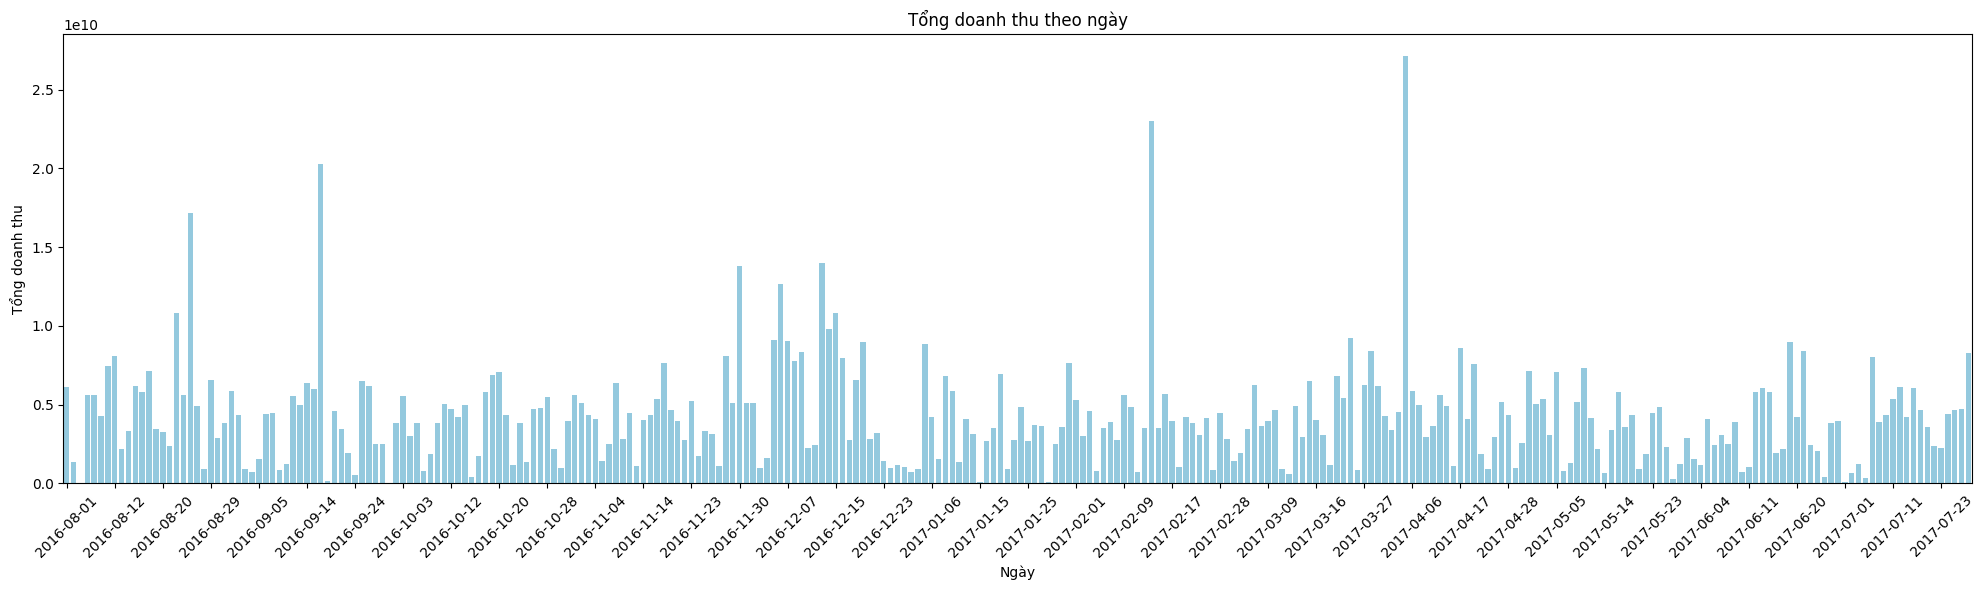

In [48]:
plt.figure(figsize=(20, 6))
sns.barplot(x=time_agg.index, y=time_agg['sum'], color='skyblue')

# Hiển thị tick cách 7 ngày
xticks = time_agg.index[::7]
plt.xticks(ticks=range(0, len(time_agg.index), 7), labels=xticks.strftime('%Y-%m-%d'), rotation=45)

plt.ylabel('Tổng doanh thu')
plt.xlabel('Ngày')
plt.title('Tổng doanh thu theo ngày')
plt.tight_layout()
plt.show()

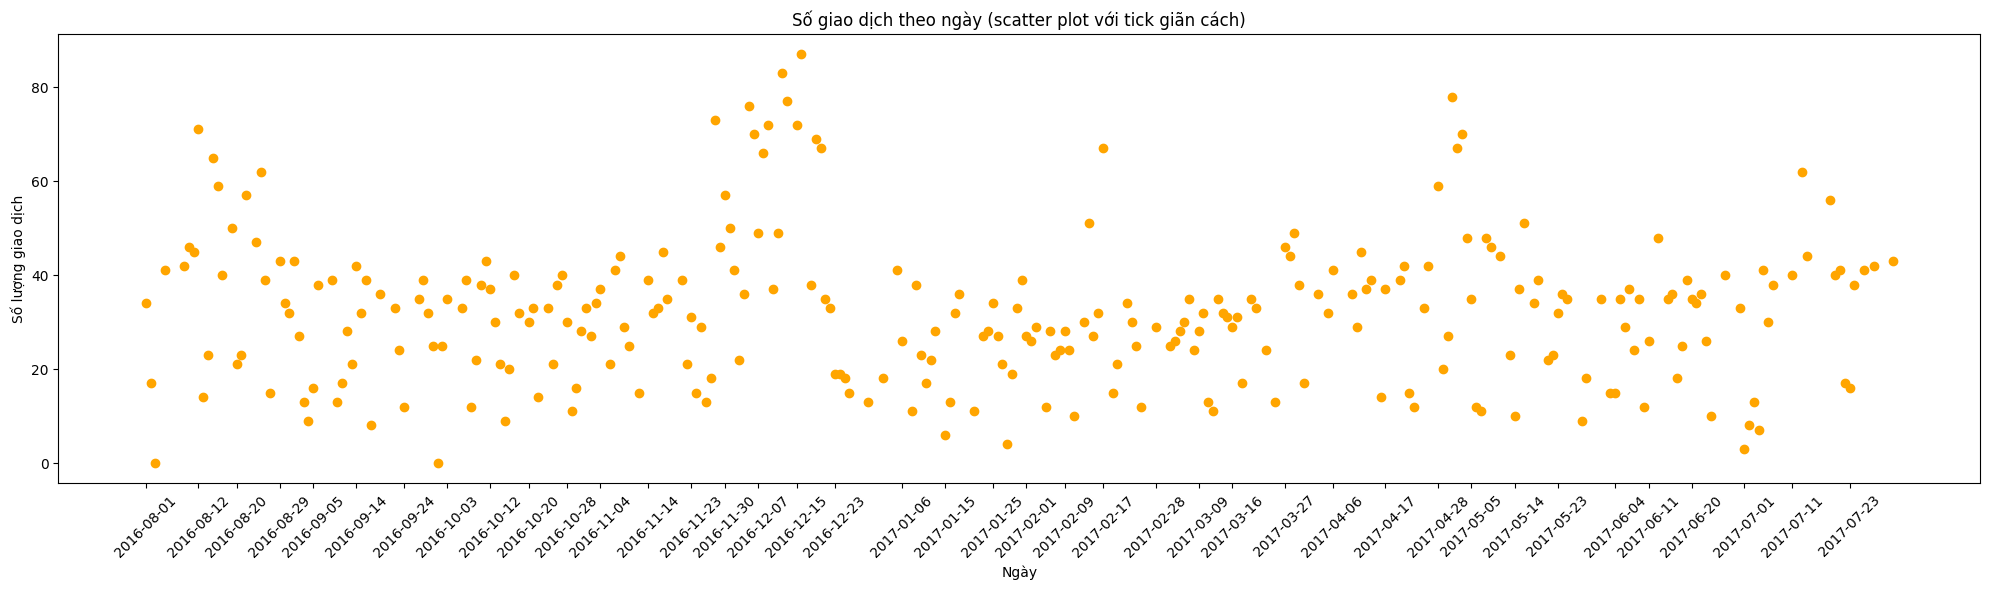

In [49]:
plt.figure(figsize=(20, 6))
plt.scatter(time_agg.index, time_agg['count'], color='orange')

xticks = time_agg.index[::7]
plt.xticks(ticks=xticks, labels=xticks.strftime('%Y-%m-%d'), rotation=45)

plt.ylabel('Số lượng giao dịch')
plt.xlabel('Ngày')
plt.title('Số giao dịch theo ngày (scatter plot với tick giãn cách)')
plt.tight_layout()
plt.show()


/tmp/ipython-input-50-4092637079.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_agg.index, y=year_agg['sum'], ax=axes[0, 0], palette='Blues_d')
/tmp/ipython-input-50-4092637079.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_agg.index, y=month_agg['sum'], ax=axes[0, 1], palette='Greens_d')
/tmp/ipython-input-50-4092637079.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_agg.index, y=day_agg['sum'], ax=axes[1, 0], palette='Oranges_d')
/tmp/ipython-input-50-4092637079.py:26: FutureWarning: 

Passing `palette`

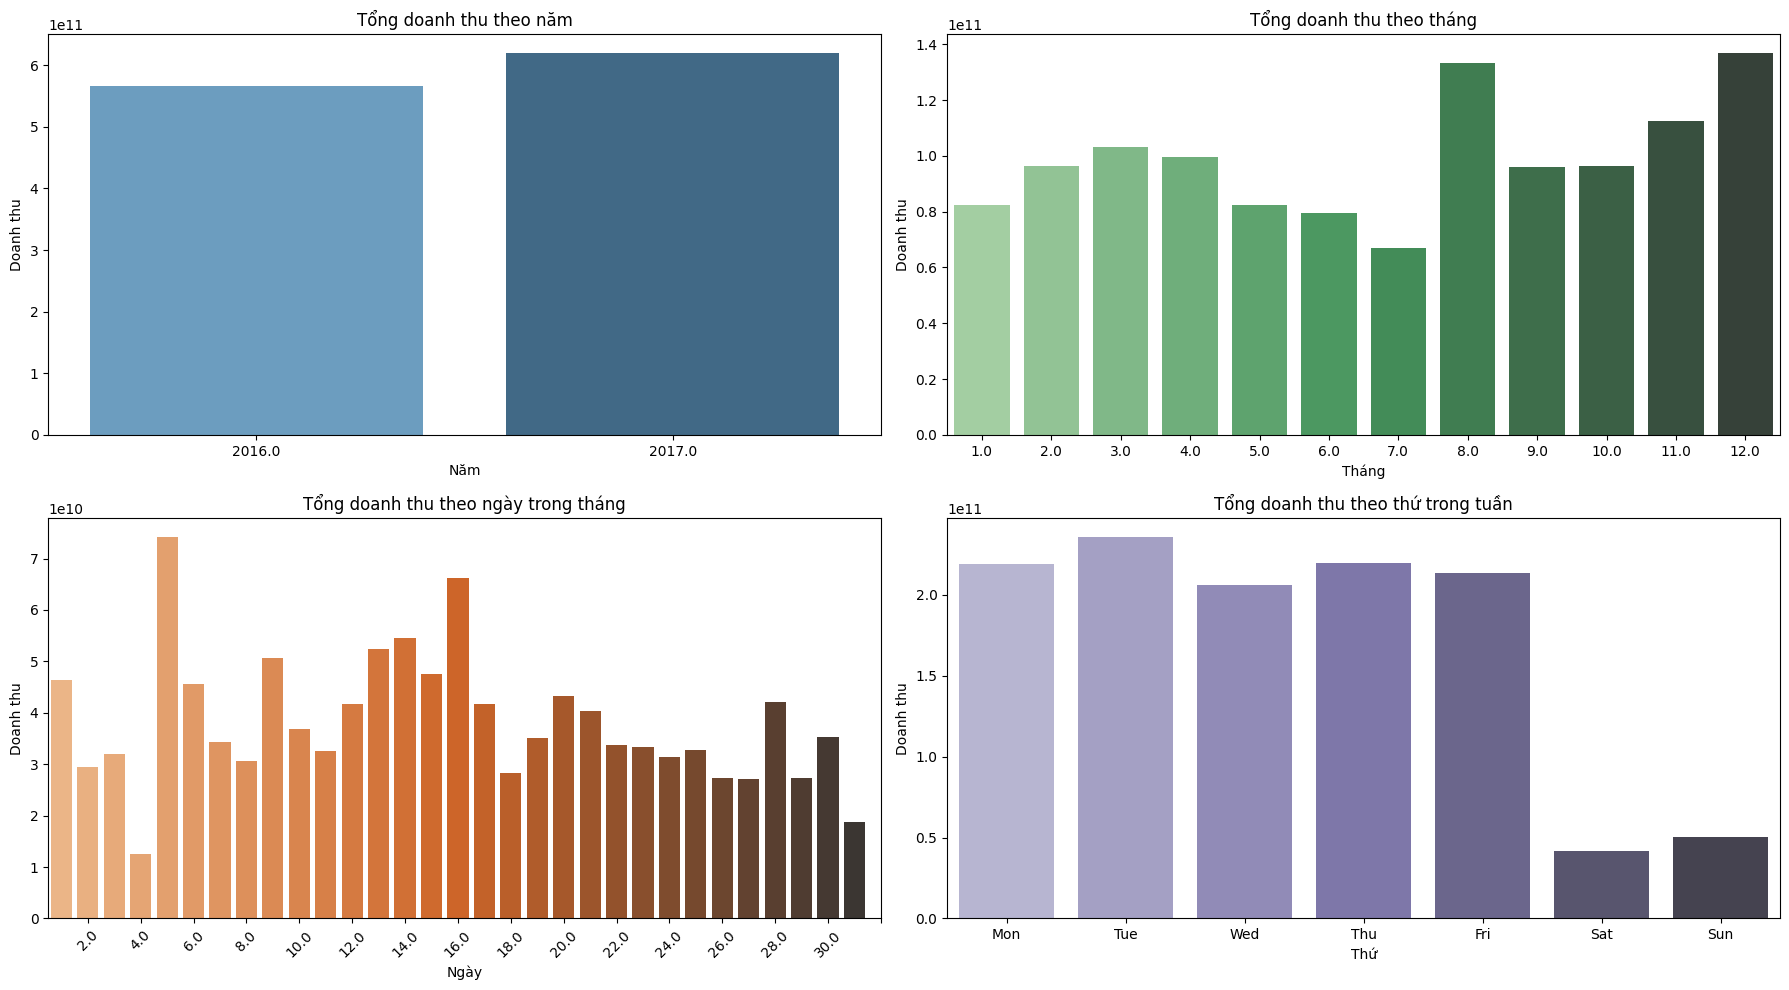

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Tổng doanh thu theo năm
sns.barplot(x=year_agg.index, y=year_agg['sum'], ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title('Tổng doanh thu theo năm')
axes[0, 0].set_xlabel('Năm')
axes[0, 0].set_ylabel('Doanh thu')

# Tổng doanh thu theo tháng
sns.barplot(x=month_agg.index, y=month_agg['sum'], ax=axes[0, 1], palette='Greens_d')
axes[0, 1].set_title('Tổng doanh thu theo tháng')
axes[0, 1].set_xlabel('Tháng')
axes[0, 1].set_ylabel('Doanh thu')

# Tổng doanh thu theo ngày trong tháng (sửa để tránh chằng chịt trục x)
sns.barplot(x=day_agg.index, y=day_agg['sum'], ax=axes[1, 0], palette='Oranges_d')
axes[1, 0].set_title('Tổng doanh thu theo ngày trong tháng')
axes[1, 0].set_xlabel('Ngày')
axes[1, 0].set_ylabel('Doanh thu')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_xticks([i for i in range(1, 32, 2)])


# Tổng doanh thu theo thứ trong tuần
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x=weekday_agg.index, y=weekday_agg['sum'], ax=axes[1, 1], palette='Purples_d')
axes[1, 1].set_title('Tổng doanh thu theo thứ trong tuần')
axes[1, 1].set_xlabel('Thứ')
axes[1, 1].set_ylabel('Doanh thu')
axes[1, 1].set_xticklabels(weekday_labels)

plt.tight_layout()
plt.show()

In [51]:
# Drop stange 'dict' column
train = train.drop(['adwordsClickInfo'], axis=1)
test = test.drop(['adwordsClickInfo'], axis=1)
# Drop column that exists only in train data
train = train.drop(['campaignCode'], axis=1)
# Input missing transactionRevenue values
train["transactionRevenue"].fillna(0, inplace=True)

test_ids = test["fullVisitorId"].values

/tmp/ipython-input-51-3639424514.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["transactionRevenue"].fillna(0, inplace=True)


In [52]:
# Cột không liên quan
unwanted_columns = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime',
                    'browser', 'browserSize', 'browserVersion', 'flashVersion',
                    'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel',
                    'mobileInputSelector', 'operatingSystemVersion', 'screenColors',
                    'metro','networkDomain', 'networkLocation', 'adContent', 'campaign',
                    'isTrueDirect', 'keyword', 'referralPath', 'source', 'operatingSystem', 'day']

train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)
# Các cột có giá trị như nhau
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)
train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)
# Cột có lượng dữ liệu > 50%
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns more than 50% null values: ', high_null_columns)
train = train.drop(high_null_columns, axis=1)
test = test.drop(high_null_columns, axis=1)

Columns with constant values:  ['socialEngagementType', 'mobileDeviceBranding', 'language', 'screenResolution', 'cityId', 'latitude', 'longitude', 'visits', 'bounces', 'newVisits']
Columns more than 50% null values:  []


In [53]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 799999
Columns: 21
Features: ['channelGrouping' 'date' 'visitNumber' 'isMobile' 'deviceCategory'
 'continent' 'subContinent' 'country' 'region' 'city' 'hits' 'pageviews'
 'transactionRevenue' 'medium' 'year' 'month' 'weekday'
 'mean_hits_per_day' 'sum_hits_per_day' 'mean_pageviews_per_day'
 'sum_pageviews_per_day']

TEST SET
Rows: 804684
Columns: 20
Features: ['channelGrouping' 'date' 'visitNumber' 'isMobile' 'deviceCategory'
 'continent' 'subContinent' 'country' 'region' 'city' 'hits' 'pageviews'
 'medium' 'year' 'month' 'weekday' 'mean_hits_per_day' 'sum_hits_per_day'
 'mean_pageviews_per_day' 'sum_pageviews_per_day']


In [54]:
categorical_features = ['isMobile', 'month', 'weekday']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

In [55]:
# Đồng bộ train, test
train, test = train.align(test, join='outer', axis=1)

# Thay giá trị NaN = 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

In [57]:
# Chuyển cột 'date' về kiểu date
train['date'] = pd.to_datetime(train['date'], errors='coerce')  # ép lại về datetime
train['date'] = train['date'].dt.date  # lấy phần ngày (bỏ giờ)

# Bây giờ có thể so sánh trực tiếp với datetime.date
X_train = train[train['date'] <= datetime.date(2017, 5, 31)]
X_val = train[train['date'] > datetime.date(2017, 5, 31)]

In [58]:
# Gán nhãn
Y_train = X_train['transactionRevenue'].values
Y_val = X_val['transactionRevenue'].values
X_train = X_train.drop(['transactionRevenue'], axis=1)
X_val = X_val.drop(['transactionRevenue'], axis=1)
test = test.drop(['transactionRevenue'], axis=1)
# Chuyển về hàm log
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

In [59]:
reduce_features = ['city', 'medium', 'channelGrouping', 'region',
                   'subContinent', 'country', 'continent', 'deviceCategory',
                   'year', 'date']
X_train = X_train.drop(reduce_features, axis=1)
X_val = X_val.drop(reduce_features, axis=1)
test = test.drop(reduce_features, axis=1)

In [60]:
X_train.head(11)

,hits,isMobile_False,isMobile_True,mean_hits_per_day,mean_pageviews_per_day,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,pageviews,sum_hits_per_day,sum_pageviews_per_day,visitNumber,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
0,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
1,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
2,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
3,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
4,1.0,False,True,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,2.0,2.0,2.0,False,False,False,False,True,False,False
5,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
6,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
7,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
8,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False
9,1.0,True,False,1.0,1.0,False,False,False,False,False,False,False,False,False,False,False,True,1.0,1.0,1.0,1.0,False,False,False,False,True,False,False


In [61]:
# Định nghĩa các cột cần chuẩn hóa và cột cần xóa
normalized_features = ['visitNumber', 'hits', 'pageviews',
                       'mean_hits_per_day', 'mean_pageviews_per_day',
                       'sum_hits_per_day', 'sum_pageviews_per_day']
reduce_features = ['city', 'medium', 'channelGrouping', 'region',
                   'subContinent', 'country', 'continent', 'deviceCategory',
                   'year', 'date']

# Đảm bảo chỉ xóa các cột trong reduce_features nếu chúng tồn tại trong DataFrame
X_train = X_train.drop(columns=reduce_features, errors='ignore')
X_val = X_val.drop(columns=reduce_features, errors='ignore')
test = test.drop(columns=reduce_features, errors='ignore')

# Lọc các cột hợp lệ để chuẩn hóa
normalized_features = [col for col in normalized_features if col in X_train.columns]

# Chuẩn hóa bằng phương pháp Min-Max scaling
scaler = preprocessing.MinMaxScaler()

if normalized_features:  # Chỉ thực hiện chuẩn hóa nếu có cột hợp lệ
    X_train[normalized_features] = scaler.fit_transform(X_train[normalized_features])
    X_val[normalized_features] = scaler.transform(X_val[normalized_features])
    test[normalized_features] = scaler.transform(test[normalized_features])


In [62]:
print(X_train.columns)
print(X_val.columns)
print(test.columns)

Index(['hits', 'isMobile_False', 'isMobile_True', 'mean_hits_per_day',
       'mean_pageviews_per_day', 'month_1.0', 'month_10.0', 'month_11.0',
       'month_12.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0',
       'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'pageviews',
       'sum_hits_per_day', 'sum_pageviews_per_day', 'visitNumber',
       'weekday_0.0', 'weekday_1.0', 'weekday_2.0', 'weekday_3.0',
       'weekday_4.0', 'weekday_5.0', 'weekday_6.0'],
      dtype='object')
Index(['hits', 'isMobile_False', 'isMobile_True', 'mean_hits_per_day',
       'mean_pageviews_per_day', 'month_1.0', 'month_10.0', 'month_11.0',
       'month_12.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0',
       'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'pageviews',
       'sum_hits_per_day', 'sum_pageviews_per_day', 'visitNumber',
       'weekday_0.0', 'weekday_1.0', 'weekday_2.0', 'weekday_3.0',
       'weekday_4.0', 'weekday_5.0', 'weekday_6.0'],
      dtype='object')
In

In [63]:
X_train.head(10)

,hits,isMobile_False,isMobile_True,mean_hits_per_day,mean_pageviews_per_day,month_1.0,month_10.0,month_11.0,month_12.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0,pageviews,sum_hits_per_day,sum_pageviews_per_day,visitNumber,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0
0,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
1,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
2,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
3,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
4,0.002,False,True,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000530,0.000633,0.005195,False,False,False,False,True,False,False
5,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
6,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
7,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
8,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False
9,0.002,True,False,0.002,0.002146,False,False,False,False,False,False,False,False,False,False,False,True,0.002132,0.000265,0.000316,0.002597,False,False,False,False,True,False,False


In [69]:
BATCH_SIZE = 64
EPOCHS = 18
LEARNING_RATE = 0.0003

In [70]:
model = Sequential()
model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))

In [71]:
adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(loss='mse', optimizer=adam)

In [72]:
print('Dataset size: %s' % X_train.shape[0])
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % X_train.shape[1])
print('Features used: %s' % X_train.columns.values)

Dataset size: 707581
Epochs: 18
Learning rate: 0.0003
Batch size: 64
Input dimension: 28
Features used: ['hits' 'isMobile_False' 'isMobile_True' 'mean_hits_per_day'
 'mean_pageviews_per_day' 'month_1.0' 'month_10.0' 'month_11.0'
 'month_12.0' 'month_2.0' 'month_3.0' 'month_4.0' 'month_5.0' 'month_6.0'
 'month_7.0' 'month_8.0' 'month_9.0' 'pageviews' 'sum_hits_per_day'
 'sum_pageviews_per_day' 'visitNumber' 'weekday_0.0' 'weekday_1.0'
 'weekday_2.0' 'weekday_3.0' 'weekday_4.0' 'weekday_5.0' 'weekday_6.0']


In [73]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,449 (158.00 KB)

 Trainable params: 40,449 (158.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - loss: 3.0326 - val_loss: 3.6826
Epoch 2/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 2.7088 - val_loss: 3.4936
Epoch 3/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - loss: 2.7176 - val_loss: 3.5115
Epoch 4/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - loss: 2.6780 - val_loss: 3.4469
Epoch 5/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - loss: 2.6098 - val_loss: 3.6906
Epoch 6/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 2.6637 - val_loss: 3.6186
Epoch 7/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 2.6366 - val_loss: 3.5572
Epoch 8/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 2.6230 - val_loss: 3.6492
Epoch 9/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 2.5787 - val_loss: 3.7091
Epoch 10/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - loss: 2.6130 - val_loss: 4.1261
Epoch 11/18
11056/11056 ━━━━━━━━━━━━━━━━━━━━ 52s 5ms/step - loss: 2.5489 - val_loss: 3.93

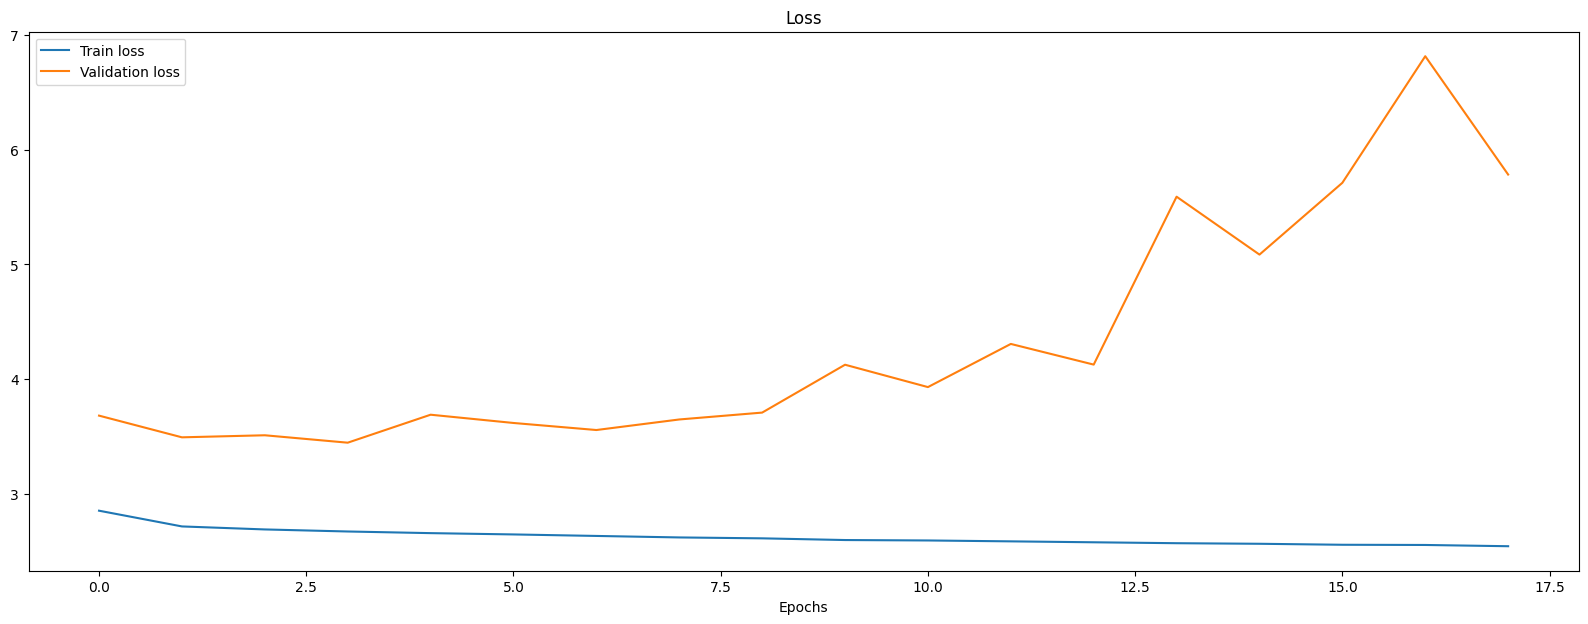

In [74]:
encoder = LabelEncoder()

# Kiểm tra xem cột có tồn tại trước khi cố gắng truy cập nó
if 'channelGrouping' in X_train.columns:
    X_train['channelGrouping'] = encoder.fit_transform(X_train['channelGrouping'].astype(str))
if 'channelGrouping' in X_val.columns:
    X_val['channelGrouping'] = encoder.transform(X_val['channelGrouping'].astype(str))
if 'channelGrouping' in test.columns:
    test['channelGrouping'] = encoder.transform(test['channelGrouping'].astype(str))

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
history = model.fit(x=X_train.values, y=Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    verbose=1, validation_data=(X_val.values, Y_val))
plot_metrics(history.history['loss'], history.history['val_loss'])

In [75]:
val_predictions = model.predict(X_val)
mse = mean_squared_error(val_predictions, Y_val)
rmse = np.sqrt(mean_squared_error(val_predictions, Y_val))

print('Model validation metrics')
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)

2889/2889 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Model validation metrics
MSE: 5.78
RMSE: 2.40


In [76]:
predictions = model.predict(test)

submission = pd.DataFrame({"fullVisitorId":test_ids})
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.to_csv("submission.csv", index=False)

25147/25147 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step


In [77]:
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.123620
1,0000049363351866189,0.077117
2,0000053049821714864,0.014216
3,0000059488412965267,0.095274
4,0000085840370633780,0.033942
5,0000091131414287111,0.020255
6,0000118334805178127,0.003122
7,0000166374699289385,0.021838
8,0000174453501096099,0.000000
9,00003038793126460,0.000000


In [80]:
# So sánh với mô hình khác
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0)
}

for name, model in models.items():
    model.fit(X_train, Y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(Y_val, preds)
    rmse = np.sqrt(mse)
    print(f"{name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}")

Random Forest - MSE: 3.39, RMSE: 1.84
XGBoost - MSE: 3.16, RMSE: 1.78
Ridge Regression - MSE: 3.62, RMSE: 1.90
